# [Remaining Useful Life Prediction Papers](https://ramtinmoslemi.github.io/RUL-Papers/)

A complete list of papers on **Remaining Useful Life (RUL) Prediction** submitted to arXiv over the past decade.

You can find the papers and their titles, abstracts, authors, links, and dates stored in [this csv file](https://github.com/RamtinMoslemi/RUL-Papers/blob/main/rul_papers.csv).



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RamtinMoslemi/RUL-Papers/blob/main/RUL_Papers.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/RamtinMoslemi/RUL-Papers/main/RUL_Papers.ipynb)

In [1]:
import re
import textwrap
import requests
import pandas as pd
import seaborn as sns
import concurrent.futures
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Extracting from arXiv

In [2]:
# @title Get papers from arXiv

month_converter = {"01": "January", "02": "February", "03": "March",
                   "04": "April", "05": "May", "06": "June",
                   "07": "July", "08": "August", "09": "September",
                   "10": "October", "11": "November", "12": "December"}


def get_page_papers(soup):
    page_papers = []

    # Find all paper entries
    paper_entries = soup.find_all('li', {'class': 'arxiv-result'})

    for entry in paper_entries:
        # Extract paper title
        title_tag = entry.find('p', {'class': 'title is-5 mathjax'})
        title = title_tag.text.strip() if title_tag else 'No Title Found'

        # Extract abstract link
        link_tag = entry.find('a', href=True)
        abstract_link = link_tag['href'] if link_tag else 'No Link Found'

        # Extract tag
        tag_tag = entry.find_all('span', {'class': 'tag'})
        tag = []
        for i in range(len(tag_tag)):
            try:
                tag.append(tag_tag[i]['data-tooltip'])
            except:
                continue
        tag = ' | '.join(tag) if len(tag) > 0 else 'No Tag Found'

        # Extract year and month from the link
        match = re.search(r'(\d{2})(\d{2})\.\d*', abstract_link)
        if match:
            year, month = str(20) + match.group(1), month_converter[match.group(2)]
        else:
            year, month = 'Unknown', 'Unknown'

        # Extract abstract text
        abstract_tag = entry.find('span', {'class': 'abstract-full has-text-grey-dark mathjax'})
        abstract = abstract_tag.text.replace('Abstract:', '').strip() if abstract_tag else "Abstract not found."
        if abstract.endswith('         △ Less'):
            abstract = abstract[:-len('         △ Less')]
        elif abstract.endswith(' △ Less'):
            abstract = abstract[:-len(' △ Less')]

        # Extract author names
        authors_tag = entry.find('p', {'class': 'authors'})
        author_names = []
        if authors_tag:
            author_tags = authors_tag.find_all('a')
            author_names = [author.text.strip() for author in author_tags]
        authors = ', '.join(author_names)

        page_papers.append({'Title': title, 'Abstract': abstract, 'Link': abstract_link, 'Tag': tag, 'Year': year, 'Month': month, 'Authors': authors})
    return page_papers


def extract_paper_info(search_keys=['Predictive Maintenance', 'Remaining Useful Life', 'State of Health'], size=200):
    papers = []
    for search_key in search_keys:
        new_papers = []
        search_key = '+'.join(search_key.split())
        url = f'https://arxiv.org/search/advanced?advanced=&terms-0-operator=AND&terms-0-term="{search_key}"&terms-0-field=all&classification-physics_archives=all&classification-include_cross_list=include&date-year=&date-filter_by=date_range&date-from_date=2014&date-to_date=&date-date_type=submitted_date_first&abstracts=show&size=200&order=-announced_date_first'

        while True:
            # Send a GET request to the search URL
            response = requests.get(url + f'&start={len(new_papers)}')
            soup = BeautifulSoup(response.content, 'html.parser')
            # Add paper from this page
            new_papers += get_page_papers(soup)
            # Stop on final page (must be fixed later)
            if len(new_papers) % size != 0:
                break
        papers += new_papers
    return pd.DataFrame(papers).sort_values(by='Link').drop_duplicates(subset='Link', keep='first').reset_index(drop=True)


def get_citation_count(arxiv_id: str):
    url = f"https://api.semanticscholar.org/v1/paper/arXiv:{arxiv_id}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        venue = data.get("venue", "Unknown")
        if venue in ["arXiv.org", ""]:
            venue = "Unknown"
        return data.get("numCitedBy", 0), venue
    return 0, "Unknown"

In [3]:
df = extract_paper_info()
arxiv_ids = [link.split("/")[-1] for link in df["Link"]]

citations, venues = [], []

# Use multi-threading to fetch data in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    results = list(executor.map(get_citation_count, arxiv_ids))

# Unpack results into lists
citations, venues = zip(*results)

df["Citation Count"] = citations
df["Venue"] = venues
df.to_csv('rul_papers.csv', index=False)
df

,Title,Abstract,Link,Tag,Year,Month,Authors,Citation Count,Venue
0,Spreading of diseases through comorbidity netw...,The state of health of patients is typically n...,https://arxiv.org/abs/1405.3801,Medical Physics | Physics and Society,2014,May,"Anna Chmiel, Peter Klimek, Stefan Thurner",72,Unknown
1,Using the Expectation Maximization Algorithm w...,Coupling a multi-capillary column (MCC) with a...,https://arxiv.org/abs/1405.5501,Other Computer Science,2014,May,"Dominik Kopczynski, Sven Rahmann",1,Unknown
2,Context-Aware Analytics in MOM Applications,Manufacturing Operations Management (MOM) syst...,https://arxiv.org/abs/1412.7968,Artificial Intelligence,2014,December,"Martin Ringsquandl, Steffen Lamparter, Raffael...",3,Unknown
3,Software that Learns from its Own Failures,All non-trivial software systems suffer from u...,https://arxiv.org/abs/1502.00821,Software Engineering,2015,February,Martin Monperrus,3,Unknown
4,Towards zero-configuration condition monitorin...,Condition-based predictive maintenance can sig...,https://arxiv.org/abs/1502.03596,Computer Vision and Pattern Recognition,2015,February,"Sergio Martin-del-Campo, Fredrik Sandin",12,European Signal Processing Conference
...,...,...,...,...,...,...,...,...,...
642,SIFBench: An Extensive Benchmark for Fatigue A...,Fatigue-induced crack growth is a leading caus...,https://arxiv.org/abs/2506.01173,Databases | Machine Learning,2025,June,"Tushar Gautam, Robert M. Kirby, Jacob Hochhalt...",0,Unknown
643,Agentic AI for Intent-Based Industrial Automation,"The recent development of Agentic AI systems, ...",https://arxiv.org/abs/2506.04980,Machine Learning | Systems and Control,2025,June,"Marcos Lima Romero, Ricardo Suyama",0,Unknown
644,Fusion of heterogeneous data for robust degrad...,Assessing the degradation state of an industri...,https://arxiv.org/abs/2506.05882,Methodology,2025,June,"Edgar Jaber, Emmanuel Remy, Vincent Chabridon,...",0,Unknown
645,Are Trees Really Green? A Detection Approach o...,"Nowadays, the Internet of Things (IoT) is wide...",https://arxiv.org/abs/2506.07836,Cryptography and Security | Artificial Intelli...,2025,June,"Silvia Lucia Sanna, Diego Soi, Davide Maiorca,...",0,Unknown


# Plots

Print the highly cited papers.

In [4]:
df = pd.read_csv('rul_papers.csv')
df.sort_values(by='Citation Count', ascending=False).head(20)

,Title,Abstract,Link,Tag,Year,Month,Authors,Citation Count,Venue
18,Gaussian process regression for forecasting ba...,Accurately predicting the future capacity and ...,https://arxiv.org/abs/1703.05687,Applications | Machine Learning,2017,March,"Robert R. Richardson, Michael A. Osborne, Davi...",527,Unknown
148,Machine learning pipeline for battery state of...,Lithium-ion batteries are ubiquitous in modern...,https://arxiv.org/abs/2102.00837,Machine Learning,2021,February,"Darius Roman, Saurabh Saxena, Valentin Robu, M...",382,Nature Machine Intelligence
9,De-identification of Patient Notes with Recurr...,Objective: Patient notes in electronic health ...,https://arxiv.org/abs/1606.03475,Computation and Language | Artificial Intellig...,2016,June,"Franck Dernoncourt, Ji Young Lee, Ozlem Uzuner...",377,J. Am. Medical Informatics Assoc.
12,Distributed and parallel time series feature e...,The all-relevant problem of feature selection ...,https://arxiv.org/abs/1610.07717,Machine Learning,2016,October,"Maximilian Christ, Andreas W. Kempa-Liehr, Mic...",274,Unknown
19,Modeling The Intensity Function Of Point Proce...,"Event sequence, asynchronously generated with ...",https://arxiv.org/abs/1705.08982,Machine Learning | Artificial Intelligence | M...,2017,May,"Shuai Xiao, Junchi Yan, Stephen M. Chu, Xiaoka...",266,AAAI Conference on Artificial Intelligence
134,Smart Anomaly Detection in Sensor Systems: A M...,Anomaly detection is concerned with identifyin...,https://arxiv.org/abs/2010.14946,Machine Learning,2020,October,"L. Erhan, M. Ndubuaku, M. Di Mauro, W. Song, M...",242,Information Fusion
94,"A Survey of Predictive Maintenance: Systems, P...",This paper highlights the importance of mainte...,https://arxiv.org/abs/1912.07383,Signal Processing | Systems and Control,2019,December,"Tianwen Zhu, Yongyi Ran, Xin Zhou, Yonggang Wen",226,Unknown
11,Multi-Sensor Prognostics using an Unsupervised...,Many approaches for estimation of Remaining Us...,https://arxiv.org/abs/1608.06154,Machine Learning | Artificial Intelligence,2016,August,"Pankaj Malhotra, Vishnu TV, Anusha Ramakrishna...",175,Unknown
182,Dual Aspect Self-Attention based on Transforme...,Remaining useful life prediction (RUL) is one ...,https://arxiv.org/abs/2106.15842,Signal Processing | Artificial Intelligence | ...,2021,June,"Zhizheng Zhang, Wen Song, Qiqiang Li",169,IEEE Transactions on Instrumentation and Measu...
255,Trends in Workplace Wearable Technologies and ...,"The workplace influences the safety, health, a...",https://arxiv.org/abs/2205.11740,Systems and Control | Signal Processing,2022,May,"Vishal Patel, Austin Chesmore, Christopher M. ...",151,Advanced Intelligent Systems


Number of papers submitted to arXiv each year.

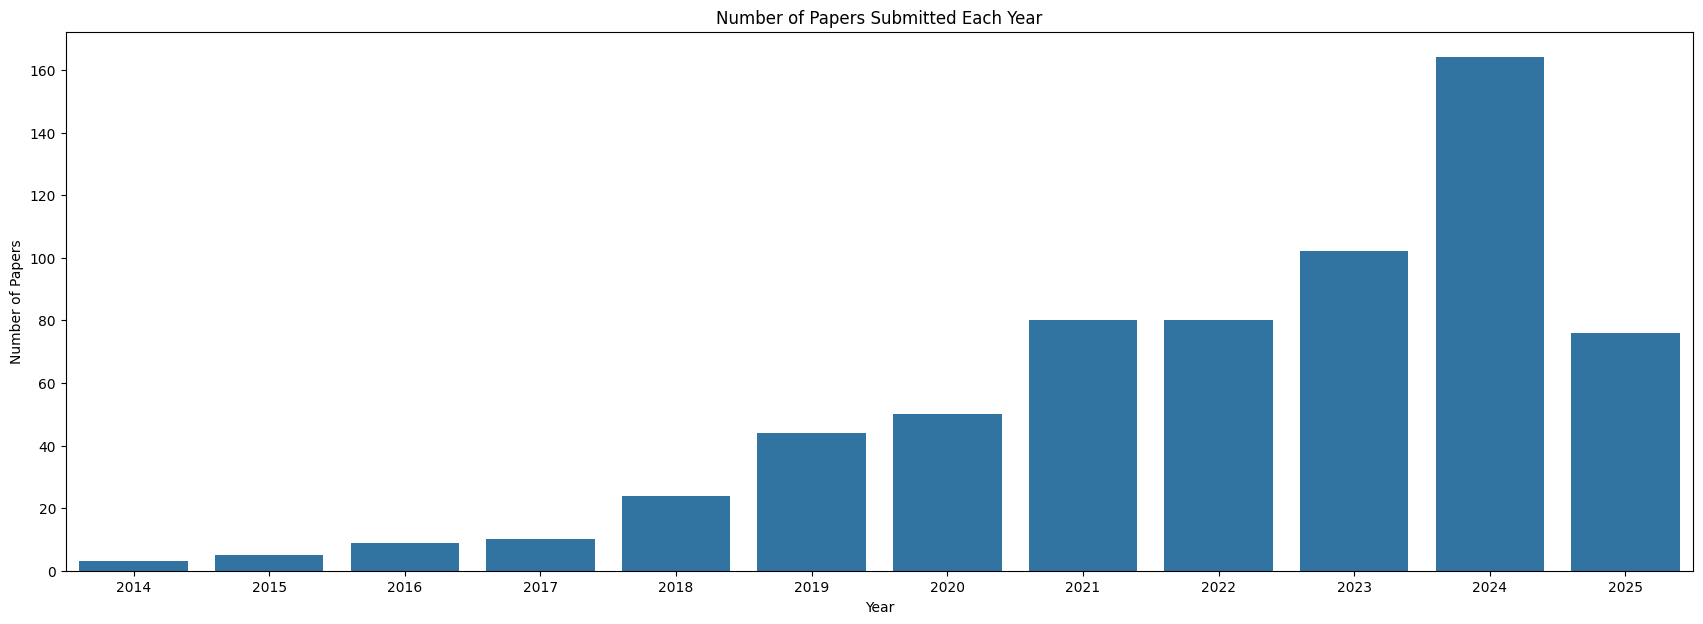

In [5]:
# Group by Year and count the number of papers
monthly_counts = df.groupby(['Year'], observed=False).size().reset_index(name='Counts')

# Create the plot
plt.figure(figsize=(21, 7))

sns.barplot(data=monthly_counts, x='Year', y='Counts')

plt.title('Number of Papers Submitted Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.savefig('paper_by_year.svg')
plt.show()

Plot the most common venues.

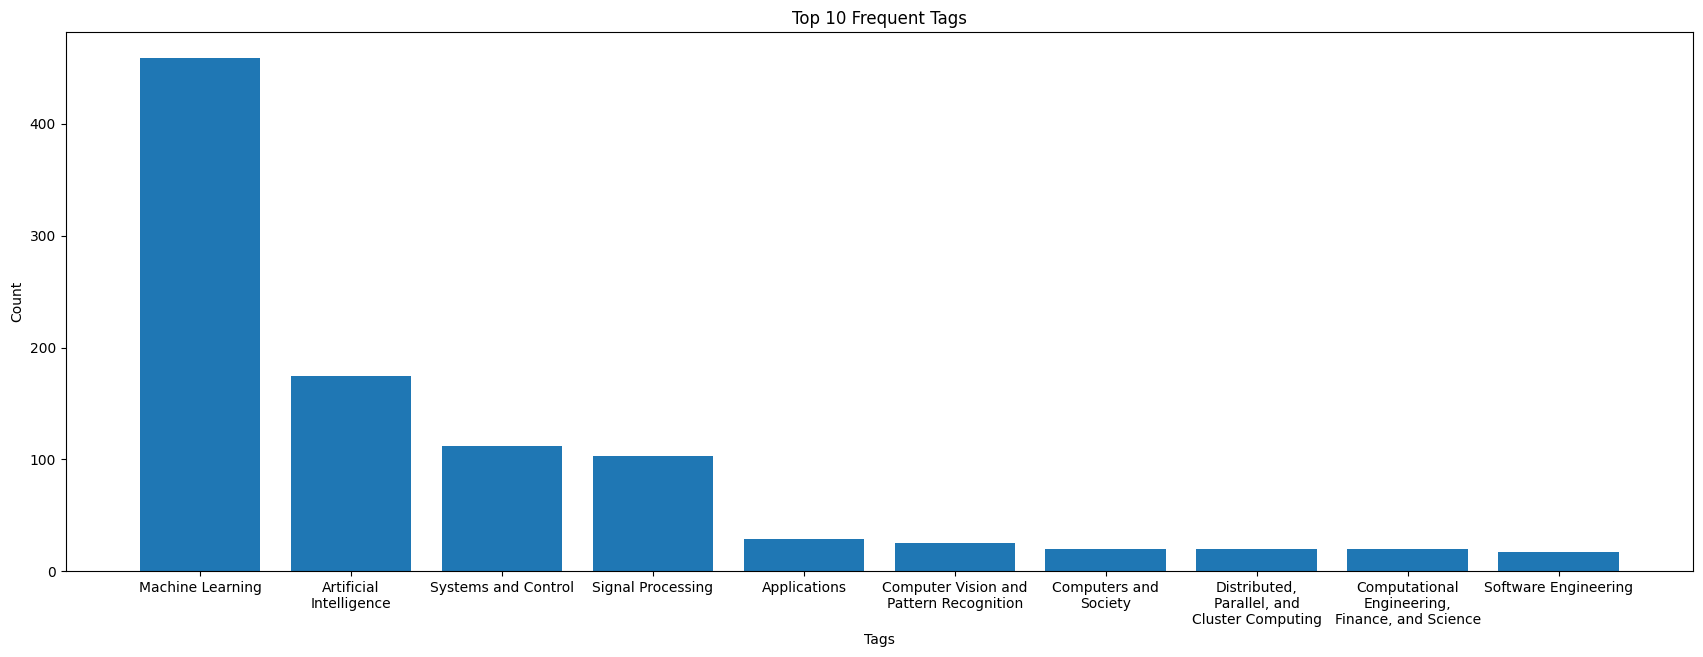

In [6]:
freq = {}
for i in range(len(df)):
    tags = df.iloc[i]['Tag'].split(' | ')
    for tag in tags:
        if tag in freq:
            freq[tag] += 1
        else:
            freq[tag] = 1
freq = dict(sorted(freq.items(), key=lambda item: item[1], reverse=True))

top = 10

plt.figure(figsize=(21, 7))
wrapped_labels = [textwrap.fill(label, width=20) for label in list(freq.keys())[:top]]
plt.bar(wrapped_labels, list(freq.values())[:top])
plt.title(f'Top {top} Frequent Tags')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.savefig('most_freq_tags.svg')
plt.show()

Plot the most frequent tags.

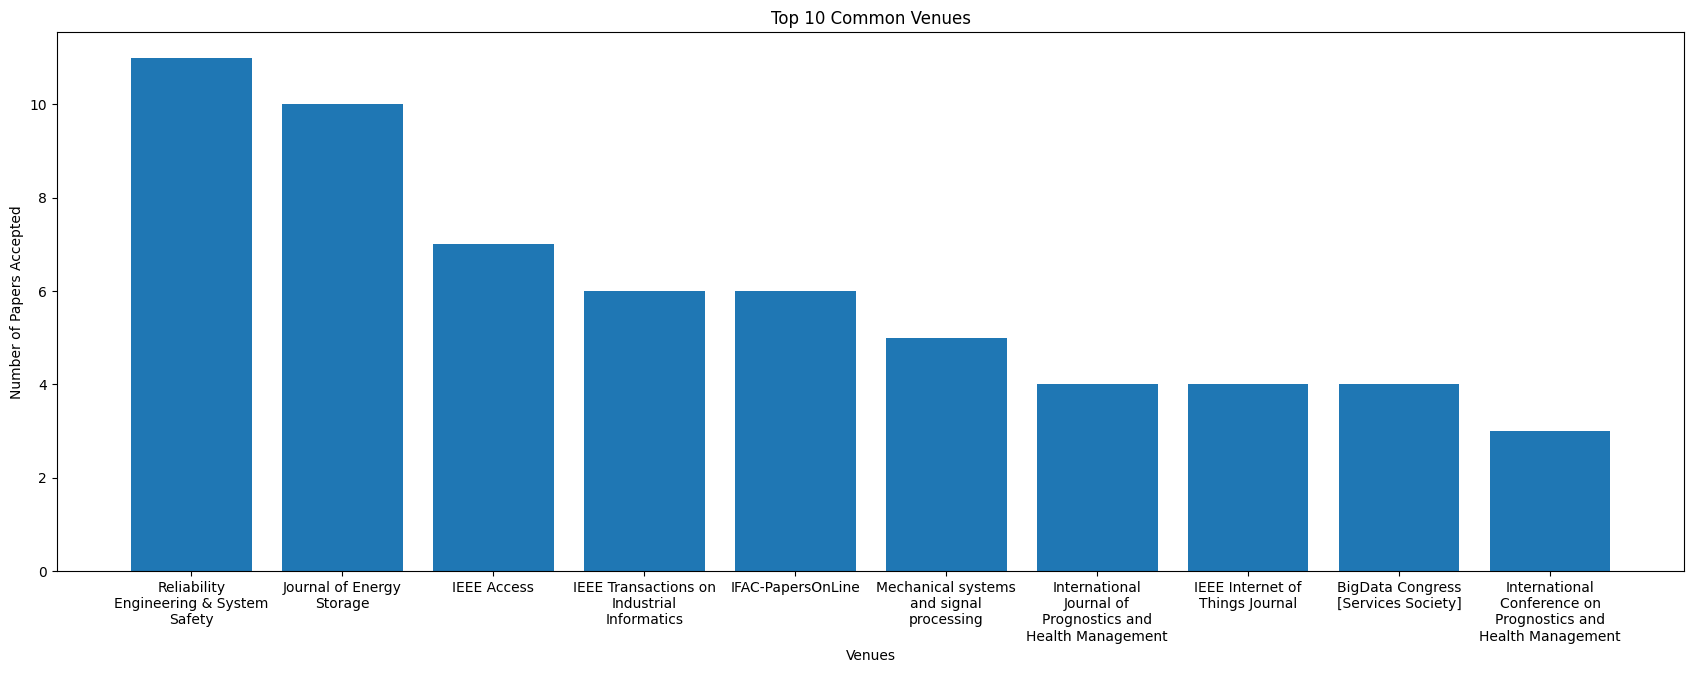

In [7]:
freq = {}
for i in range(len(df)):
    venue = df.iloc[i]['Venue']
    if venue in freq:
        freq[venue] += 1
    else:
        freq[venue] = 1
freq['Unknown'] = 0
freq = dict(sorted(freq.items(), key=lambda item: item[1], reverse=True))
top = 10

plt.figure(figsize=(21, 7))
wrapped_labels = [textwrap.fill(label, width=20) for label in list(freq.keys())[:top]]
plt.bar(wrapped_labels, list(freq.values())[:top])
plt.title(f'Top {top} Common Venues')
plt.xlabel('Venues')
plt.ylabel('Number of Papers Accepted')
plt.savefig('most_freq_venues.svg')
plt.show()

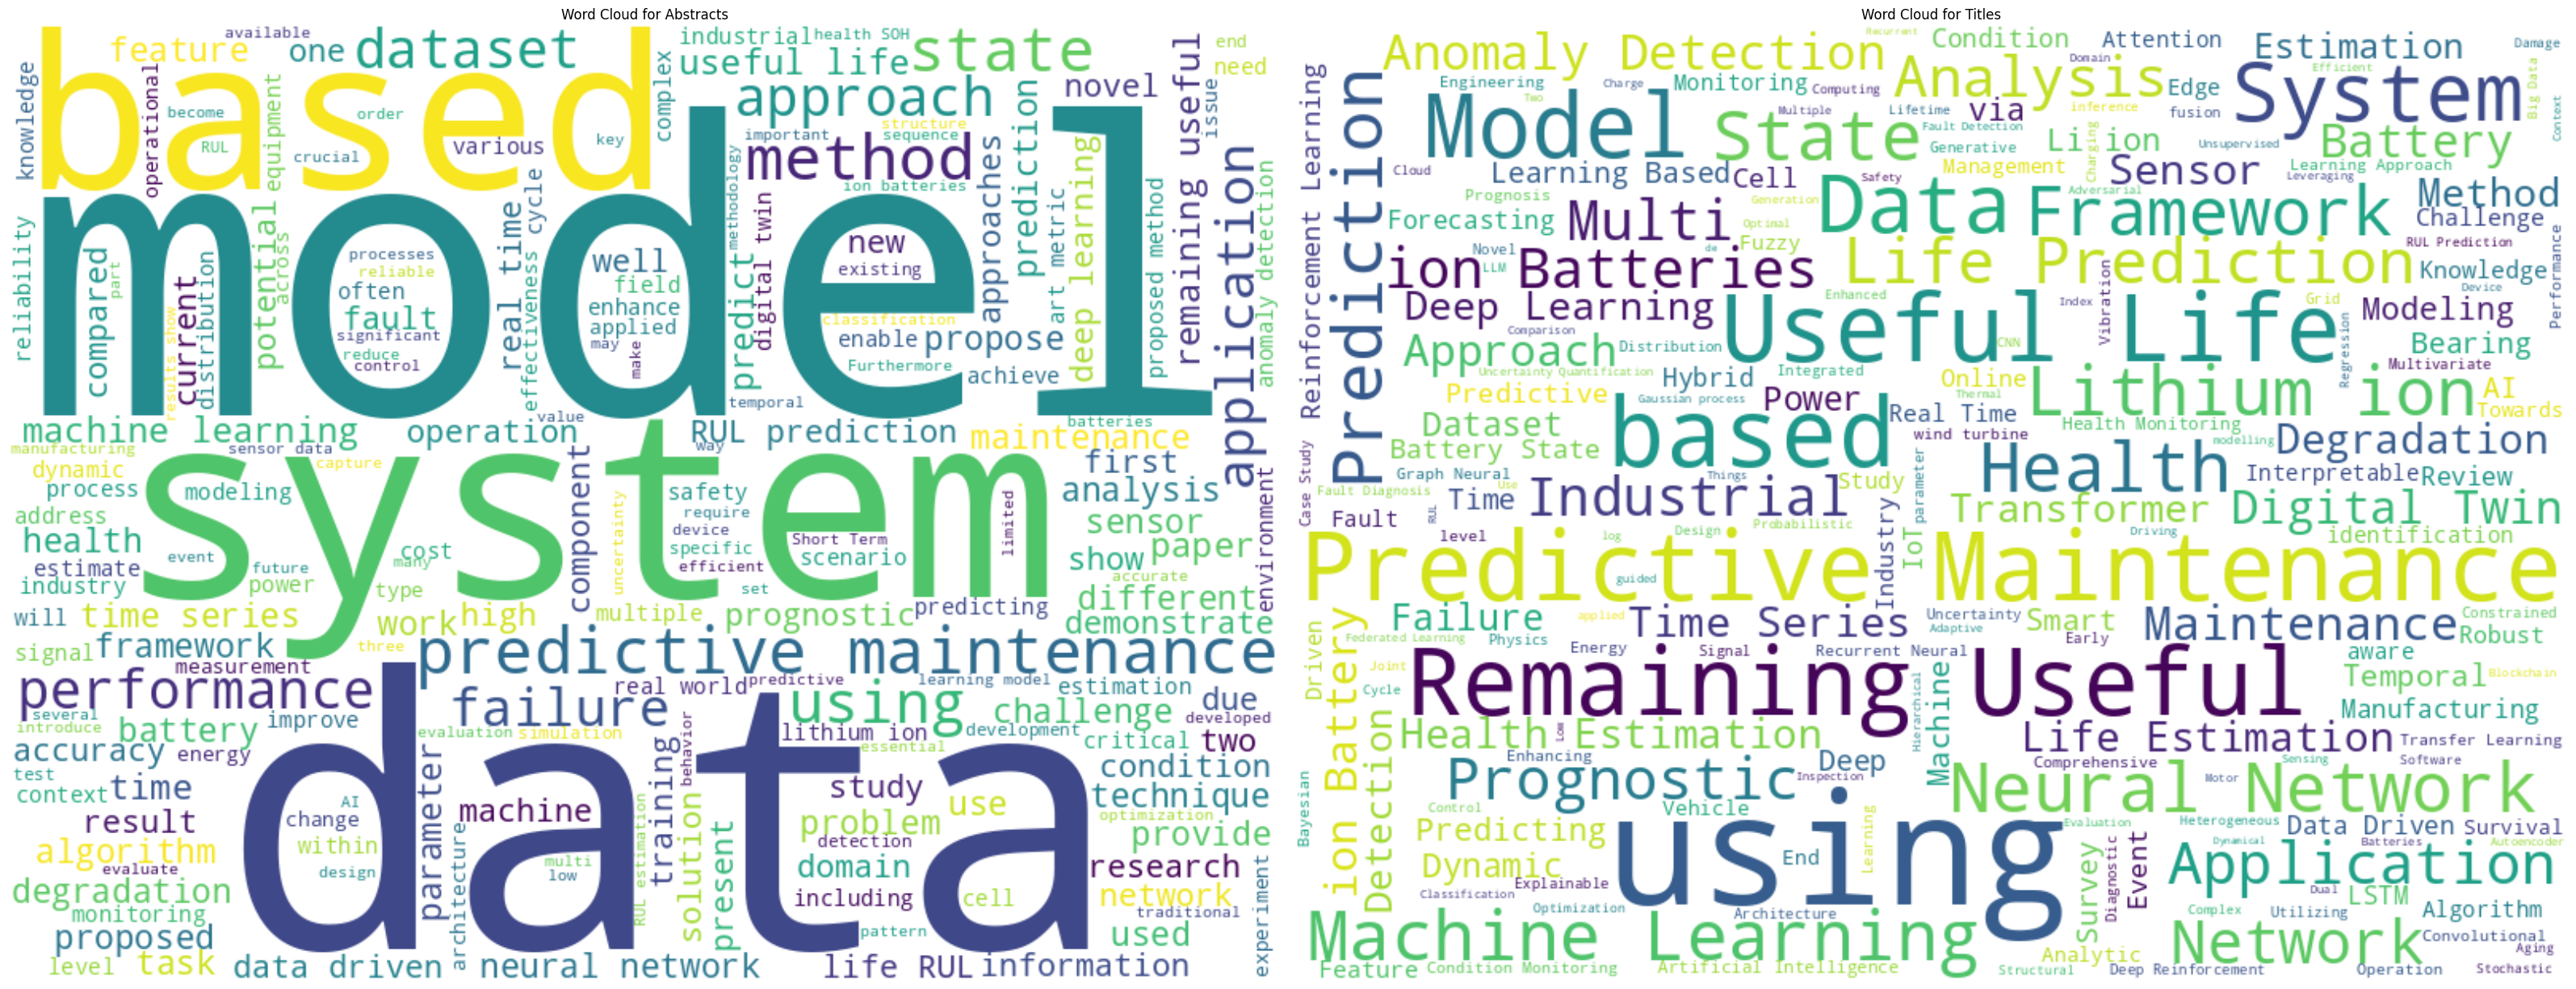

In [8]:
# Generate word cloud for abstracts
abstract_text = " ".join(df['Abstract'].dropna().tolist())
wordcloud_abstract = WordCloud(width=800, height=600, background_color='white').generate(abstract_text)

# Generate word cloud for titles
title_text = " ".join(df['Title'].dropna().tolist())
wordcloud_title = WordCloud(width=800, height=600, background_color='white').generate(title_text)

# Plot the word clouds
plt.figure(figsize=(32, 13))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_abstract, interpolation='bilinear')
plt.title('Word Cloud for Abstracts')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.title('Word Cloud for Titles')
plt.axis('off')

plt.tight_layout()
plt.savefig('word_clouds.png')
plt.show()

# README

In [9]:
# @title create read me file
def create_readme():
    year, month = None, None
    header = '# [Remaining Useful Life Prediction Papers](https://ramtinmoslemi.github.io/RUL-Papers/)\nA complete list of papers on **Remaining Useful Life (RUL) Prediction**, **State of Health (SOH) Prediction**, and **Predictive Maintenance (PdM)** submitted to arXiv over the past decade.\n\nYou can find the papers and their titles, abstracts, authors, links, and dates stored in [this csv file](https://github.com/RamtinMoslemi/RUL-Papers/blob/main/rul_papers.csv).\n\n'
    header += '## Paper Counts by Year\nNumber of papers submitted to arXiv by year.\n\n![yearly_papers](figures/paper_by_year.svg)\n\n'
    header += '## Most Popular Venues\nVenues with highest number of papers.\n\n![venues](figures/most_freq_venues.svg)\n\n'
    header += '## Most Common Tags\nMost common arXiv tags for papers.\n\n![venues](figures/most_freq_tags.svg)\n\n'
    header += '## Word Clouds\nWord clouds of paper titles and abstracts.\n\n![word_clouds](figures/word_clouds.png)\n\n'
    header += '## Notebook\nYou can play with the notebook:\n\n'
    header += '[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RamtinMoslemi/RUL-Papers/blob/main/RUL_Papers.ipynb) [![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/RamtinMoslemi/RUL-Papers/main/RUL_Papers.ipynb)\n\n\n'
    with open('README.md', 'w', encoding='utf-8') as file:
        file.write(header)
        for i in range(len(df)):
            if df.iloc[i]['Year'] != year:
                year = df.iloc[i]['Year']
                file.write(f'# {year}\n')
            if df.iloc[i]['Month'] != month:
                month = df.iloc[i]['Month']
                file.write(f'## {month}\n')
            file.write(f"### [{df.iloc[i]['Title']}]({df.iloc[i]['Link']})\n\n")
            if len(df.iloc[i]['Authors'].split(',')) != 1:
                file.write(f"**Authors:**\n{df.iloc[i]['Authors']}\n\n")
            else:
                file.write(f"**Author:**\n{df.iloc[i]['Authors']}\n\n")
            if df.iloc[i]['Venue'] != 'Unknown':
                file.write(f"**Venue:**\n{df.iloc[i]['Venue']}\n\n")
            if df.iloc[i]['Citation Count'] != 0:
                file.write(f"**Citation Count:**\n{df.iloc[i]['Citation Count']}\n\n")
            file.write(f"**Abstract:**\n{df.iloc[i]['Abstract']}\n\n\n")

In [10]:
create_readme()